In [9]:
# imported dependencies
import pennylane as qml
import numpy as np
import random
import stabilizer as stabilizers
from scipy.linalg import expm
from helper_functions import generate_density_matrix

'0.28.0'

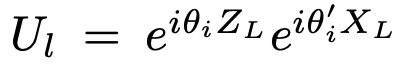

In [2]:
# Generates one unitary gate
def get_unitary_gate(ZL, XL):
  theta_i = np.random.uniform(0, 2*np.pi)
  theta_i_prime = np.random.uniform(0, 2*np.pi)
  exp_Z_L = expm(1j * theta_i * ZL)
  exp_X_L = expm(1j * theta_i_prime * XL)
    
  return exp_Z_L @ exp_X_L

In [3]:
# Generate a list of L unitary gates to apply to the density matrix 
def get_ulist(length, ZL, XL):
    u_list = []
    for i in range(length):
        u_list.append(get_unitary_gate(ZL, XL))
    return u_list

In [4]:
def generate_zero_density_matrix():
    state = np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    rho = np.outer(state, np.conj(state).T)
    return rho

In [5]:
def generate_noiseless_state(u_list):
    pid = generate_zero_density_matrix()
    for U in u_list:
       pid = U @ pid @ U.conj().T
    return pid


In [6]:
def generate_VQED(L,sep):
    # Length L because we have L ancilla qubits 
    estimation_wires = [i for i in range(int(L/sep))]
    
    # 4 because that is the size of our stabilizers
    target_wires = [int(L/sep) + i for i in range(4)]
    dev = qml.device("default.mixed", wires=(len(estimation_wires+target_wires)))
    @qml.qnode(dev)
    def VQED(stabilizer_list, unitary_list, O):
        for wire in estimation_wires:
            qml.Hadamard(wires=wire)
        for l in range(len(estimation_wires)):
            s_i = stabilizer_list[l][0]
            s_j = stabilizer_list[l][1]
            for separation in range(sep):
                U = unitary_list[sep*l+separation]
                qml.QubitUnitary(U, wires=target_wires)
            qml.BitFlip(0.1, wires=estimation_wires[l])
            qml.ControlledQubitUnitary(s_i, control_wires=estimation_wires[l], wires=target_wires, control_values="0")
            qml.ControlledQubitUnitary(s_j, control_wires=estimation_wires[l], wires=target_wires, control_values="1")
        prod = qml.PauliX(estimation_wires[0])
        for wire in range(1,len(estimation_wires)):
            prod = prod @ qml.PauliX(estimation_wires[wire])

        return qml.expval(prod), qml.expval(qml.Hermitian(O, wires=target_wires))
    return VQED

In [7]:
# NOTE: This code will fail to run as pennylane only supports mixed devices with up to a maximum of 23 wires #

G_list = stabilizers.get_4_1_2()[:-2]
S_list = stabilizers.get_stabilizers(G_list)
ZL = G_list[-2]
XL = G_list[-1]

N = 10
infidelities = {}

# L sep
combinations = [(100,50),(80,20),(80,80), (100,5), (100,10), (100,20), (100,100)]
# hardcode L to 5 since running it anymore takes too long
for l,sep in combinations:
    a = 0
    b = 0  
    VQED = generate_VQED(l,sep)
    U_list = get_ulist(l, ZL, XL)
    noiseless_state = generate_noiseless_state(U_list)
    s_sample = [random.sample(S_list, 2) for i in range(int(l/sep))]
    for i in range(N):
        a_s, O_measurement = VQED(s_sample, U_list, noiseless_state)
        b_s = a_s * O_measurement
        a += a_s
        b += b_s
    print("a is " + str(a))
    print("b is " + str(b))
    print("infidelity: "+ str(1-b/a))
    infidelities[(l,sep)] = 1 - b/a
    print(infidelities)



a is 0.0
b is 0.0
infidelity: nan
{(100, 50): nan}


<ipython-input-7-441c63bc3c2c>:26: RuntimeWarning: invalid value encountered in double_scalars
  print("infidelity: "+ str(1-b/a))
<ipython-input-7-441c63bc3c2c>:27: RuntimeWarning: invalid value encountered in double_scalars
  infidelities[(l,sep)] = 1 - b/a


a is 10.000000000000782
b is 5.000000000000788
infidelity: 0.49999999999996025
{(100, 50): nan, (80, 20): 0.49999999999996025}
a is 10.000000000000197
b is 0.0
infidelity: 1.0
{(100, 50): nan, (80, 20): 0.49999999999996025, (80, 80): 1.0}


ValueError: This device does not currently support computations on more than 23 wires